In [1]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import os
os.chdir("/content/drive/My Drive")

# Results on non-rotated test set

## Collect non-rotated test set

In [4]:
test_dir = 'project3_data/data/test_images/'
label_dir = 'project3_data/data/test_labels/'
test_images = {}
test_labels = {}

string='32F25Dr3WsreA7D'
file_path = "models/U_net_" + string + ".h5"

filenames = []
for dirs, subdirs, files in os.walk(test_dir):
    for name in files:
        filenames.append(name)
        path_to_use = os.path.join(dirs, name)
        if path_to_use.endswith('.npy'):
            test_images[name]=np.load(path_to_use)
            test_labels[name]=np.load(os.path.join(label_dir, name))
            print(f"file: {name}, shape: {test_images[name].shape}, classes: {np.unique(test_labels[name])}")  

file: sample-51.npy, shape: (14, 256, 256), classes: [0 1 2]
file: sample-55.npy, shape: (17, 256, 256), classes: [0 1 2]
file: sample-58.npy, shape: (20, 256, 256), classes: [0 1 2]
file: sample-53.npy, shape: (20, 256, 256), classes: [0 1 2]
file: sample-50.npy, shape: (15, 256, 256), classes: [0 1 2]
file: sample-59.npy, shape: (15, 256, 256), classes: [0 1 2]
file: sample-52.npy, shape: (21, 256, 256), classes: [0 1 2]
file: sample-56.npy, shape: (15, 256, 256), classes: [0 1 2]
file: sample-57.npy, shape: (19, 256, 256), classes: [0 1 2]
file: sample-54.npy, shape: (19, 256, 256), classes: [0 1 2]


In [5]:
num_images = 0
for name in filenames:
    num_images += test_images[name].shape[0]
print(num_images)

175


## Exclude sample-52.npy due to higher image dimensions

In [6]:
X_test = np.zeros([num_images, 256, 256], dtype=np.float32)
Y_test = np.zeros([num_images, 256, 256], dtype=np.int8)

ind = 0
for name in filenames:
    for i in range(test_images[name].shape[0]):
        if test_images[name].shape[1] != 256:
          continue
                  
        X_test[ind] = test_images[name][i]
        Y_test[ind] = test_labels[name][i]
            
        ind = ind + 1
print(ind)
print(X_test.shape, Y_test.shape)

175
(175, 256, 256) (175, 256, 256)


In [7]:
np.unique(Y_test)

array([0, 1, 2], dtype=int8)

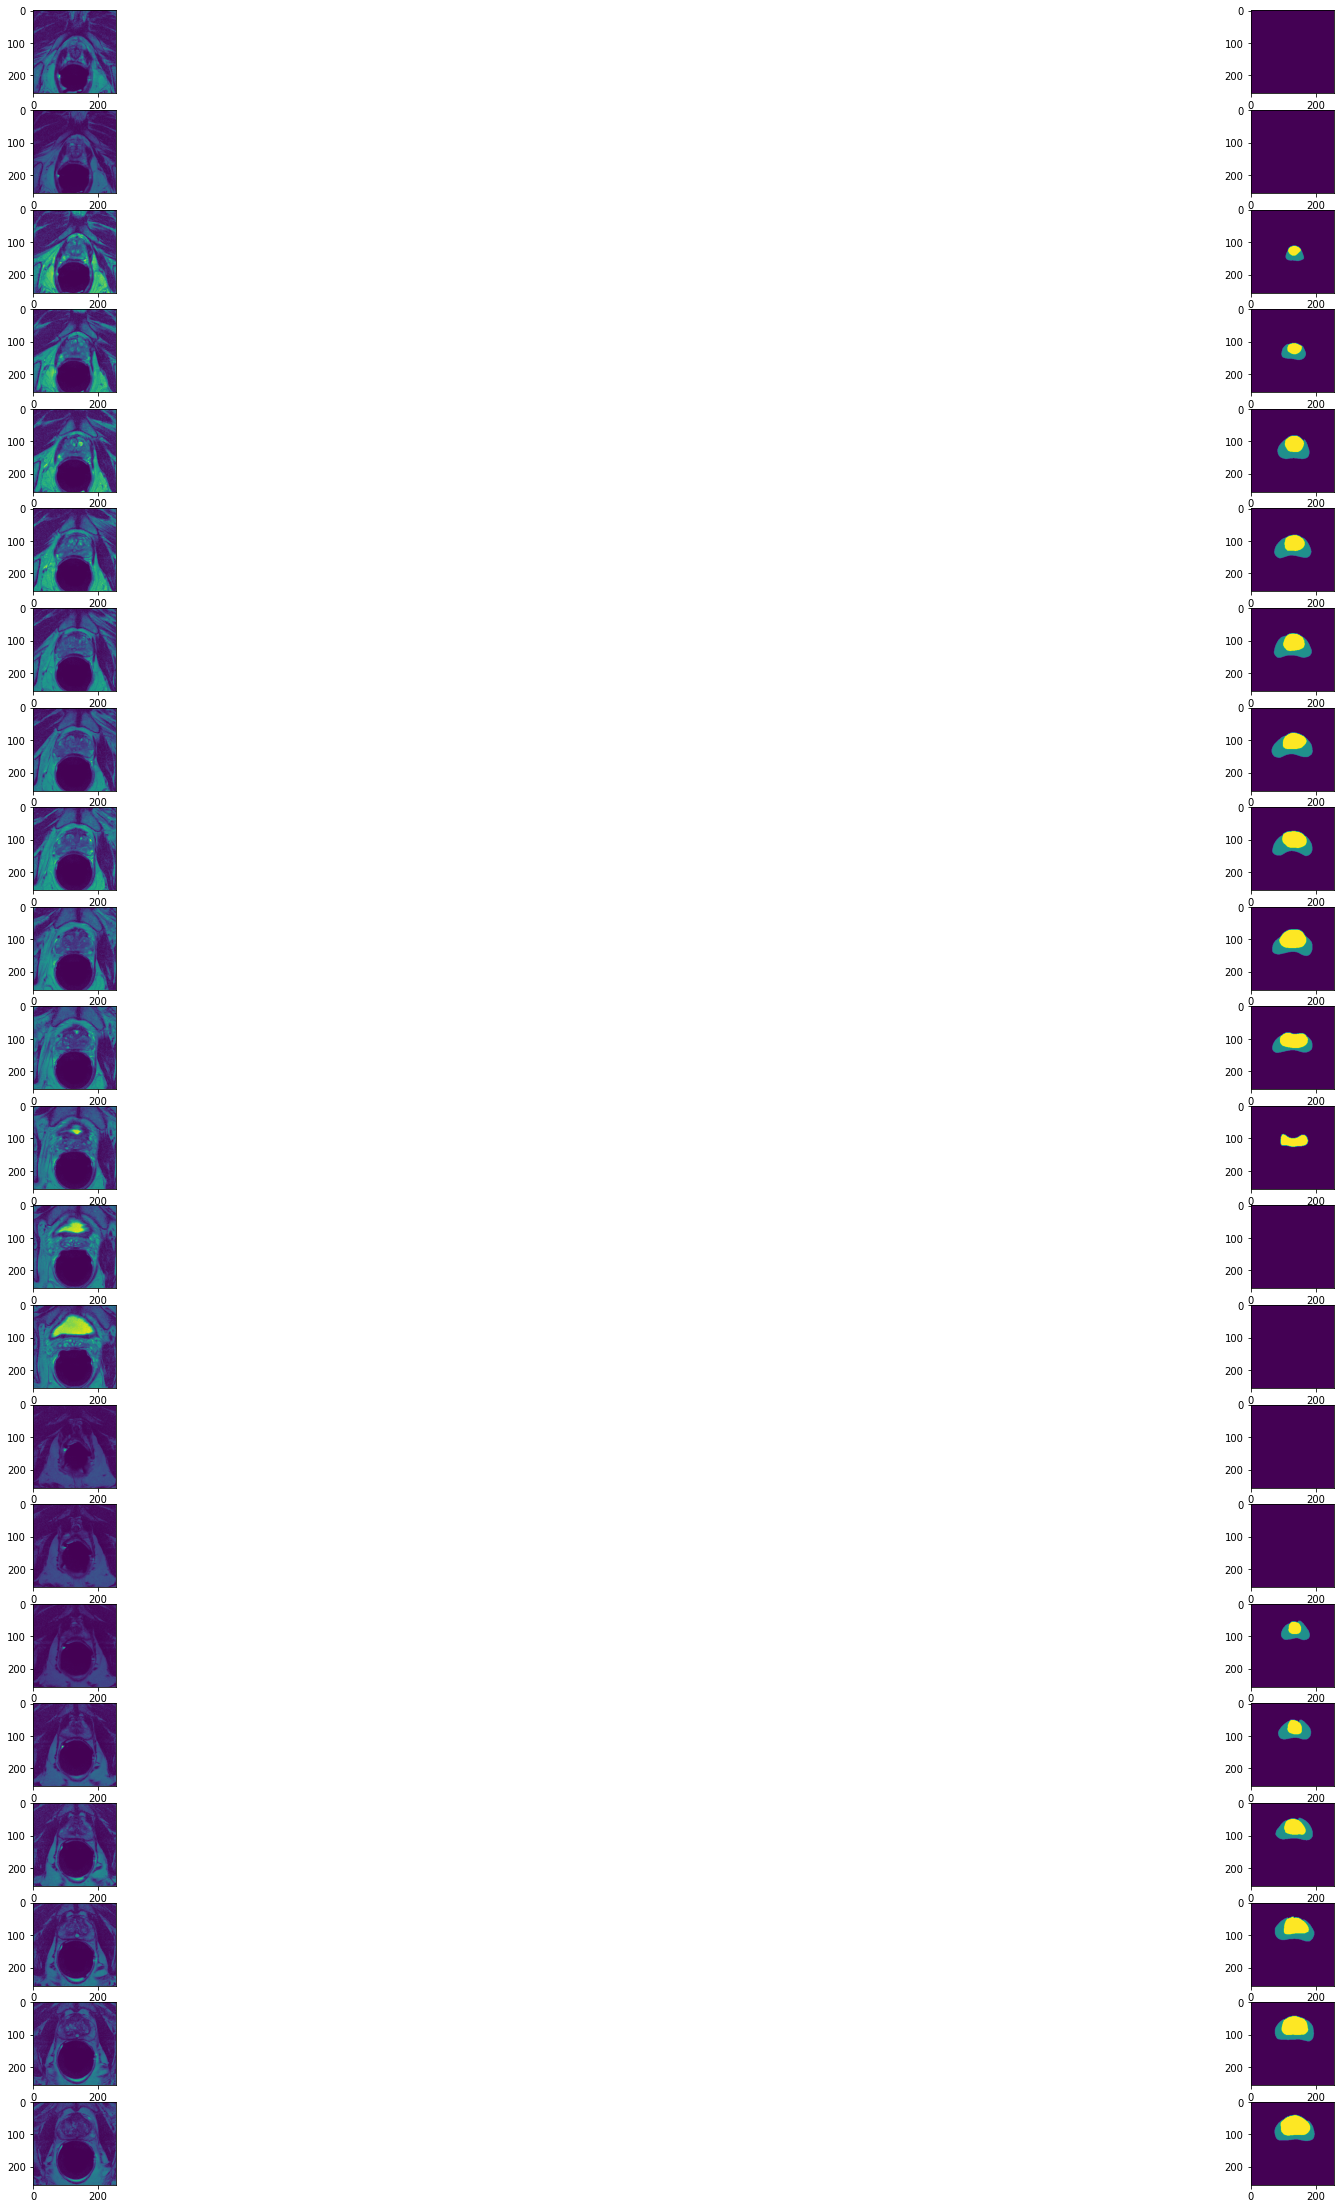

In [8]:
plt.figure(figsize=(40,40))
for i in range (0, 22):
    plt.subplot(22, 2, 2*i+1)
    plt.imshow(X_test[i,:,:])#, cmap="bone", origin="lower"
    plt.subplot(22, 2, 2*i+2)
    plt.imshow(Y_test[i,:,:])

## Normalize the input images

In [9]:
def normalize(image):
    denominator = np.amax(image)
    return image/denominator

print("Range of input values: %s" % {np.amin(X_test), np.amax(X_test)})

X_test = X_test.astype('float32')

for i in range(X_test.shape[0]):
    X_test[i] = normalize(X_test[i])
    
X_test = X_test[..., np.newaxis]

print("Normalized range of input values: %s" % {np.amin(X_test), np.amax(X_test)})
print("Normalized input image shape: %s" % (X_test.shape,))
print("Normalized image dtype: %s" % (X_test.dtype))

Range of input values: {0.0, 2441.0}
Normalized range of input values: {0.0, 1.0}
Normalized input image shape: (175, 256, 256, 1)
Normalized image dtype: float32


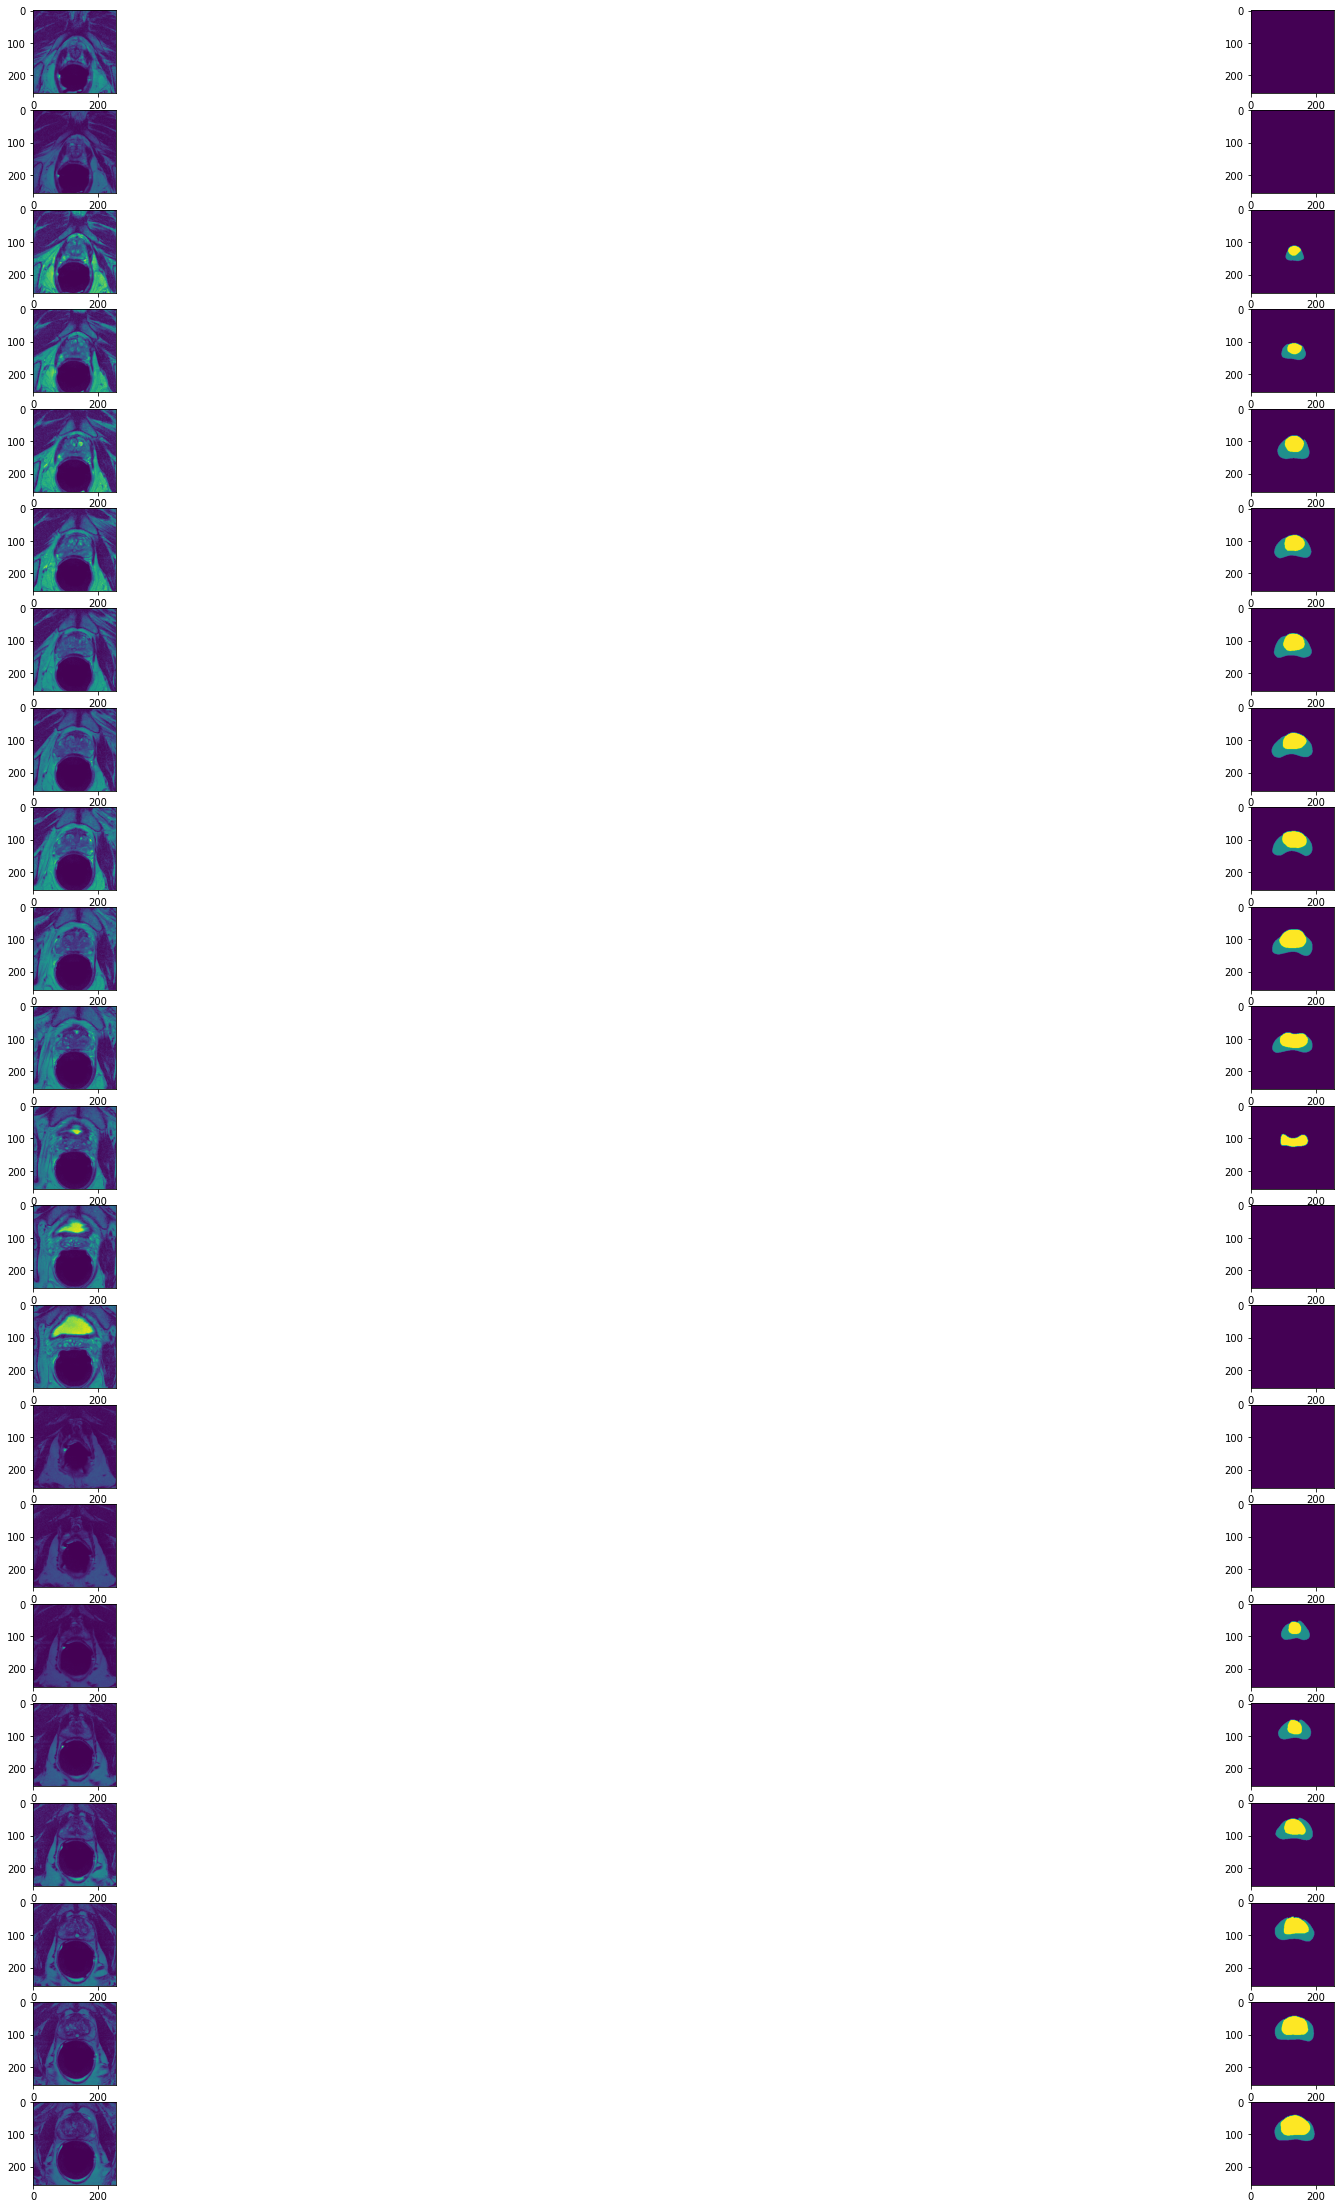

In [10]:
plt.figure(figsize=(40,40))
for i in range (0, 22):
    plt.subplot(22, 2, 2*i+1)
    plt.imshow(X_test[i,:,:,0])#, cmap="bone", origin="lower"
    plt.subplot(22, 2, 2*i+2)
    plt.imshow(Y_test[i,:,:])

## Convert the labels to categorical vectors

In [11]:
Y_test_vec = np.reshape(Y_test, [Y_test.shape[0], Y_test.shape[1]*Y_test.shape[2]])
print("Vectorized new label shape: %s" % (Y_test_vec.shape,))

Vectorized new label shape: (175, 65536)


## Get predicted labels from the best model after grid search

In [12]:
U_net = tf.keras.models.load_model('models/U_net_' + string)
U_net.load_weights(file_path)

Y_pred = U_net.predict(X_test)
Y_pred.shape

(175, 65536, 3)

## Evaluate the U-net

In [13]:
Y_pred = np.argmax(Y_pred, axis=-1)
print("New predicted labels shape: %s " % (Y_pred.shape,))

New predicted labels shape: (175, 65536) 


In [14]:
def get_scores(y_true, y_pred):
    results=[]
    y_true=y_true.flatten()
    y_pred=y_pred.flatten()
    #Overall precision
    results.append(metrics.precision_score(y_true, y_pred, average='micro'))
    #Per-class precision
    results.append(metrics.precision_score(y_true, y_pred, average='macro'))
    #jaccard (right average?)
    results.append(metrics.jaccard_score(y_true, y_pred, average='macro'))
    return results
get_scores(Y_test_vec, Y_pred)

[0.9545867919921875, 0.8173793524243256, 0.5390105265241224]

In [15]:
def get_scores(y_true, y_pred):
    results=[]
    y_true=y_true.flatten()
    y_pred=y_pred.flatten()
    #Overall precision
    results.append(metrics.precision_score(y_true, y_pred, average='micro'))
    #Per-class precision
    results.append(metrics.precision_score(y_true, y_pred, average='weighted'))
    #jaccard (right average?)
    results.append(metrics.jaccard_score(y_true, y_pred, average='weighted'))
    return results
get_scores(Y_test_vec, Y_pred)

[0.9545867919921875, 0.9480496167929008, 0.9169984107850113]

## Plot outcome

In [16]:
# reshape back to original dimensions
Y_pred_org = np.reshape(Y_pred, [Y_pred.shape[0], 256, 256])
print(Y_pred_org.shape)

(175, 256, 256)


In [17]:
np.unique(Y_pred_org)

array([0, 1, 2])

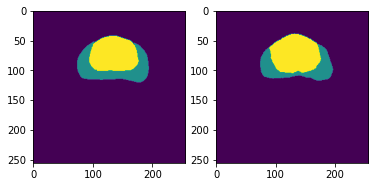

In [18]:
ind = 20
plt.subplot(1,2,1)
plt.imshow(Y_test[ind])
plt.subplot(1,2,2)
plt.imshow(Y_pred_org[ind])

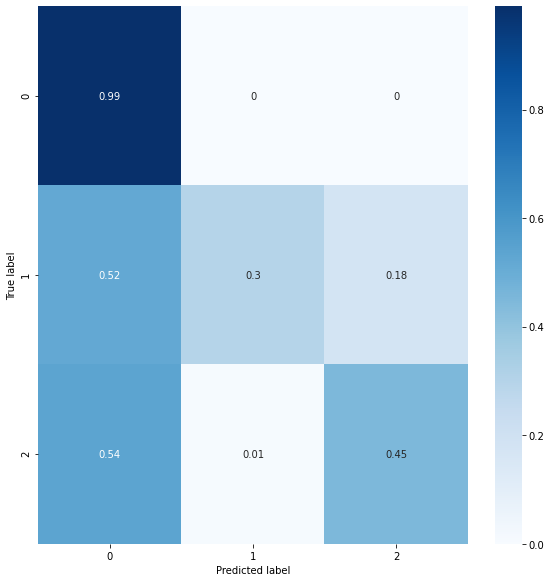

In [19]:
classes=[0,1,2]

con_mat = tf.math.confusion_matrix(labels=Y_test_vec.flatten(), predictions=Y_pred.flatten()).numpy()

# Normalization of Confusion Matrix to the interpretation of which class is being misclassified.
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
 
con_mat_df = pd.DataFrame(con_mat_norm, index = classes, columns = classes)

# plot confusion matrix
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Results on rotated test set

In [20]:
test_dir_rot = 'project3_data/data/test_images_randomly_rotated/'
label_dir_rot = 'project3_data/data/test_labels_randomly_rotated/'
test_images_rot = {}
test_labels_rot = {}

filenames_rot = []
for dirs, subdirs, files in os.walk(test_dir_rot):
    for name in files:
        filenames_rot.append(name)
        path_to_use = os.path.join(dirs, name)
        if path_to_use.endswith('.npy'):
            test_images_rot[name]=np.load(path_to_use)
            test_labels_rot[name]=np.load(os.path.join(label_dir_rot, name))
            print(f"file: {name}, shape: {test_images_rot[name].shape}, classes: {np.unique(test_labels_rot[name])}")  

file: sample-58.npy, shape: (20, 256, 256), classes: [0 1 2]
file: sample-54.npy, shape: (19, 256, 256), classes: [0 1 2 3]
file: sample-59.npy, shape: (15, 256, 256), classes: [0 1 2]
file: sample-57.npy, shape: (19, 256, 256), classes: [0 1 2]
file: sample-53.npy, shape: (20, 256, 256), classes: [0 1 2 3]
file: sample-55.npy, shape: (17, 256, 256), classes: [0 1 2]
file: sample-52.npy, shape: (21, 256, 256), classes: [0 1 2]
file: sample-56.npy, shape: (15, 256, 256), classes: [0 1 2]
file: sample-50.npy, shape: (15, 256, 256), classes: [0 1 2]
file: sample-51.npy, shape: (14, 256, 256), classes: [0 1 2]


## Treat label 3 as label 1 in sample-53 and sample-54

In [0]:
test_labels_rot['sample-53.npy'][test_labels_rot['sample-53.npy']==3] = 1
test_labels_rot['sample-54.npy'][test_labels_rot['sample-54.npy']==3] = 1

In [22]:
for name in filenames_rot:
    print(f"file: {name}, shape: {test_images_rot[name].shape}, classes: {np.unique(test_labels_rot[name])}") 

file: sample-58.npy, shape: (20, 256, 256), classes: [0 1 2]
file: sample-54.npy, shape: (19, 256, 256), classes: [0 1 2]
file: sample-59.npy, shape: (15, 256, 256), classes: [0 1 2]
file: sample-57.npy, shape: (19, 256, 256), classes: [0 1 2]
file: sample-53.npy, shape: (20, 256, 256), classes: [0 1 2]
file: sample-55.npy, shape: (17, 256, 256), classes: [0 1 2]
file: sample-52.npy, shape: (21, 256, 256), classes: [0 1 2]
file: sample-56.npy, shape: (15, 256, 256), classes: [0 1 2]
file: sample-50.npy, shape: (15, 256, 256), classes: [0 1 2]
file: sample-51.npy, shape: (14, 256, 256), classes: [0 1 2]


In [23]:
num_images_rot = 0
for name in filenames_rot:
    num_images_rot += test_images_rot[name].shape[0]
print(num_images_rot)

175


In [24]:
X_test_rot = np.zeros([num_images_rot, 256, 256], dtype=np.float32)
Y_test_rot = np.zeros([num_images_rot, 256, 256], dtype=np.int8)

ind = 0
for name in filenames_rot:
    for i in range (0, test_images_rot[name].shape[0]):
                   
        X_test_rot[ind] = test_images_rot[name][i]
        Y_test_rot[ind] = test_labels_rot[name][i]
            
        ind = ind + 1
print(X_test_rot.shape, Y_test_rot.shape)

(175, 256, 256) (175, 256, 256)


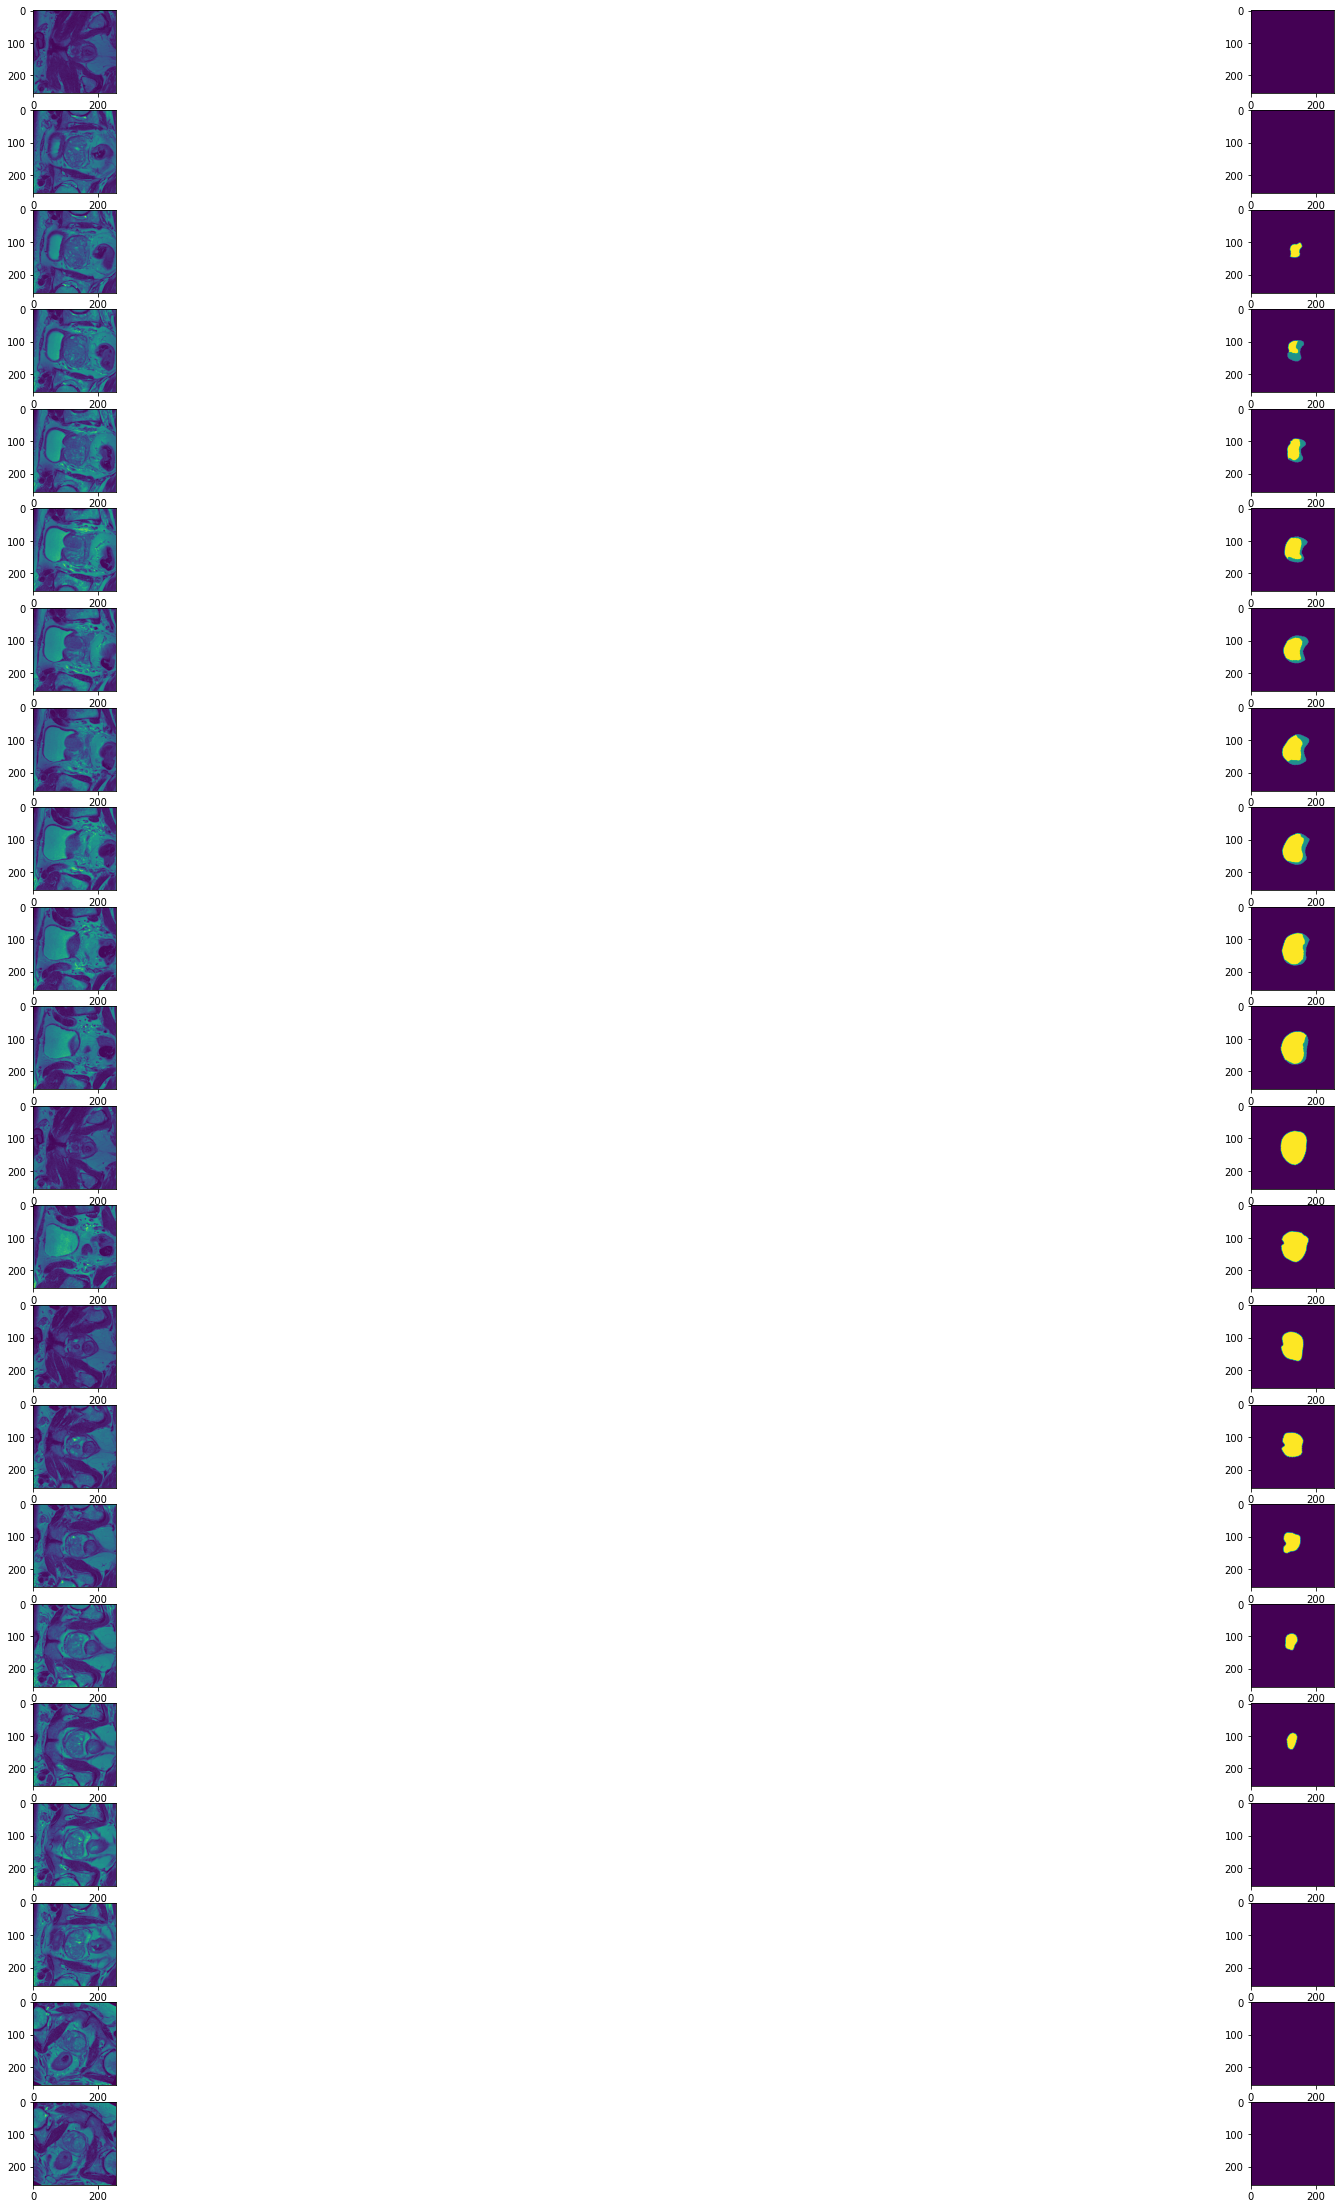

In [25]:
plt.figure(figsize=(40,40))
for i in range (0, 22):
    plt.subplot(22, 2, 2*i+1)
    plt.imshow(X_test_rot[i,:,:])
    plt.subplot(22, 2, 2*i+2)
    plt.imshow(Y_test_rot[i,:,:])

## Normalize the input images

In [26]:
def normalize(image):
    denominator = np.amax(image)
    return image/denominator

print("Range of input values: %s" % {np.amin(X_test_rot), np.amax(X_test_rot)})

X_test_rot = X_test_rot.astype('float32')

for i in range(X_test_rot.shape[0]):
    X_test_rot[i] = normalize(X_test_rot[i])
    
X_test_rot = X_test_rot[..., np.newaxis]

print("Normalized range of input values: %s" % {np.amin(X_test_rot), np.amax(X_test_rot)})
print("Normalized input image shape: %s" % (X_test_rot.shape,))
print("Normalized image dtype: %s" % (X_test_rot.dtype))

Range of input values: {0.0, 1851.0}
Normalized range of input values: {0.0, 1.0}
Normalized input image shape: (175, 256, 256, 1)
Normalized image dtype: float32


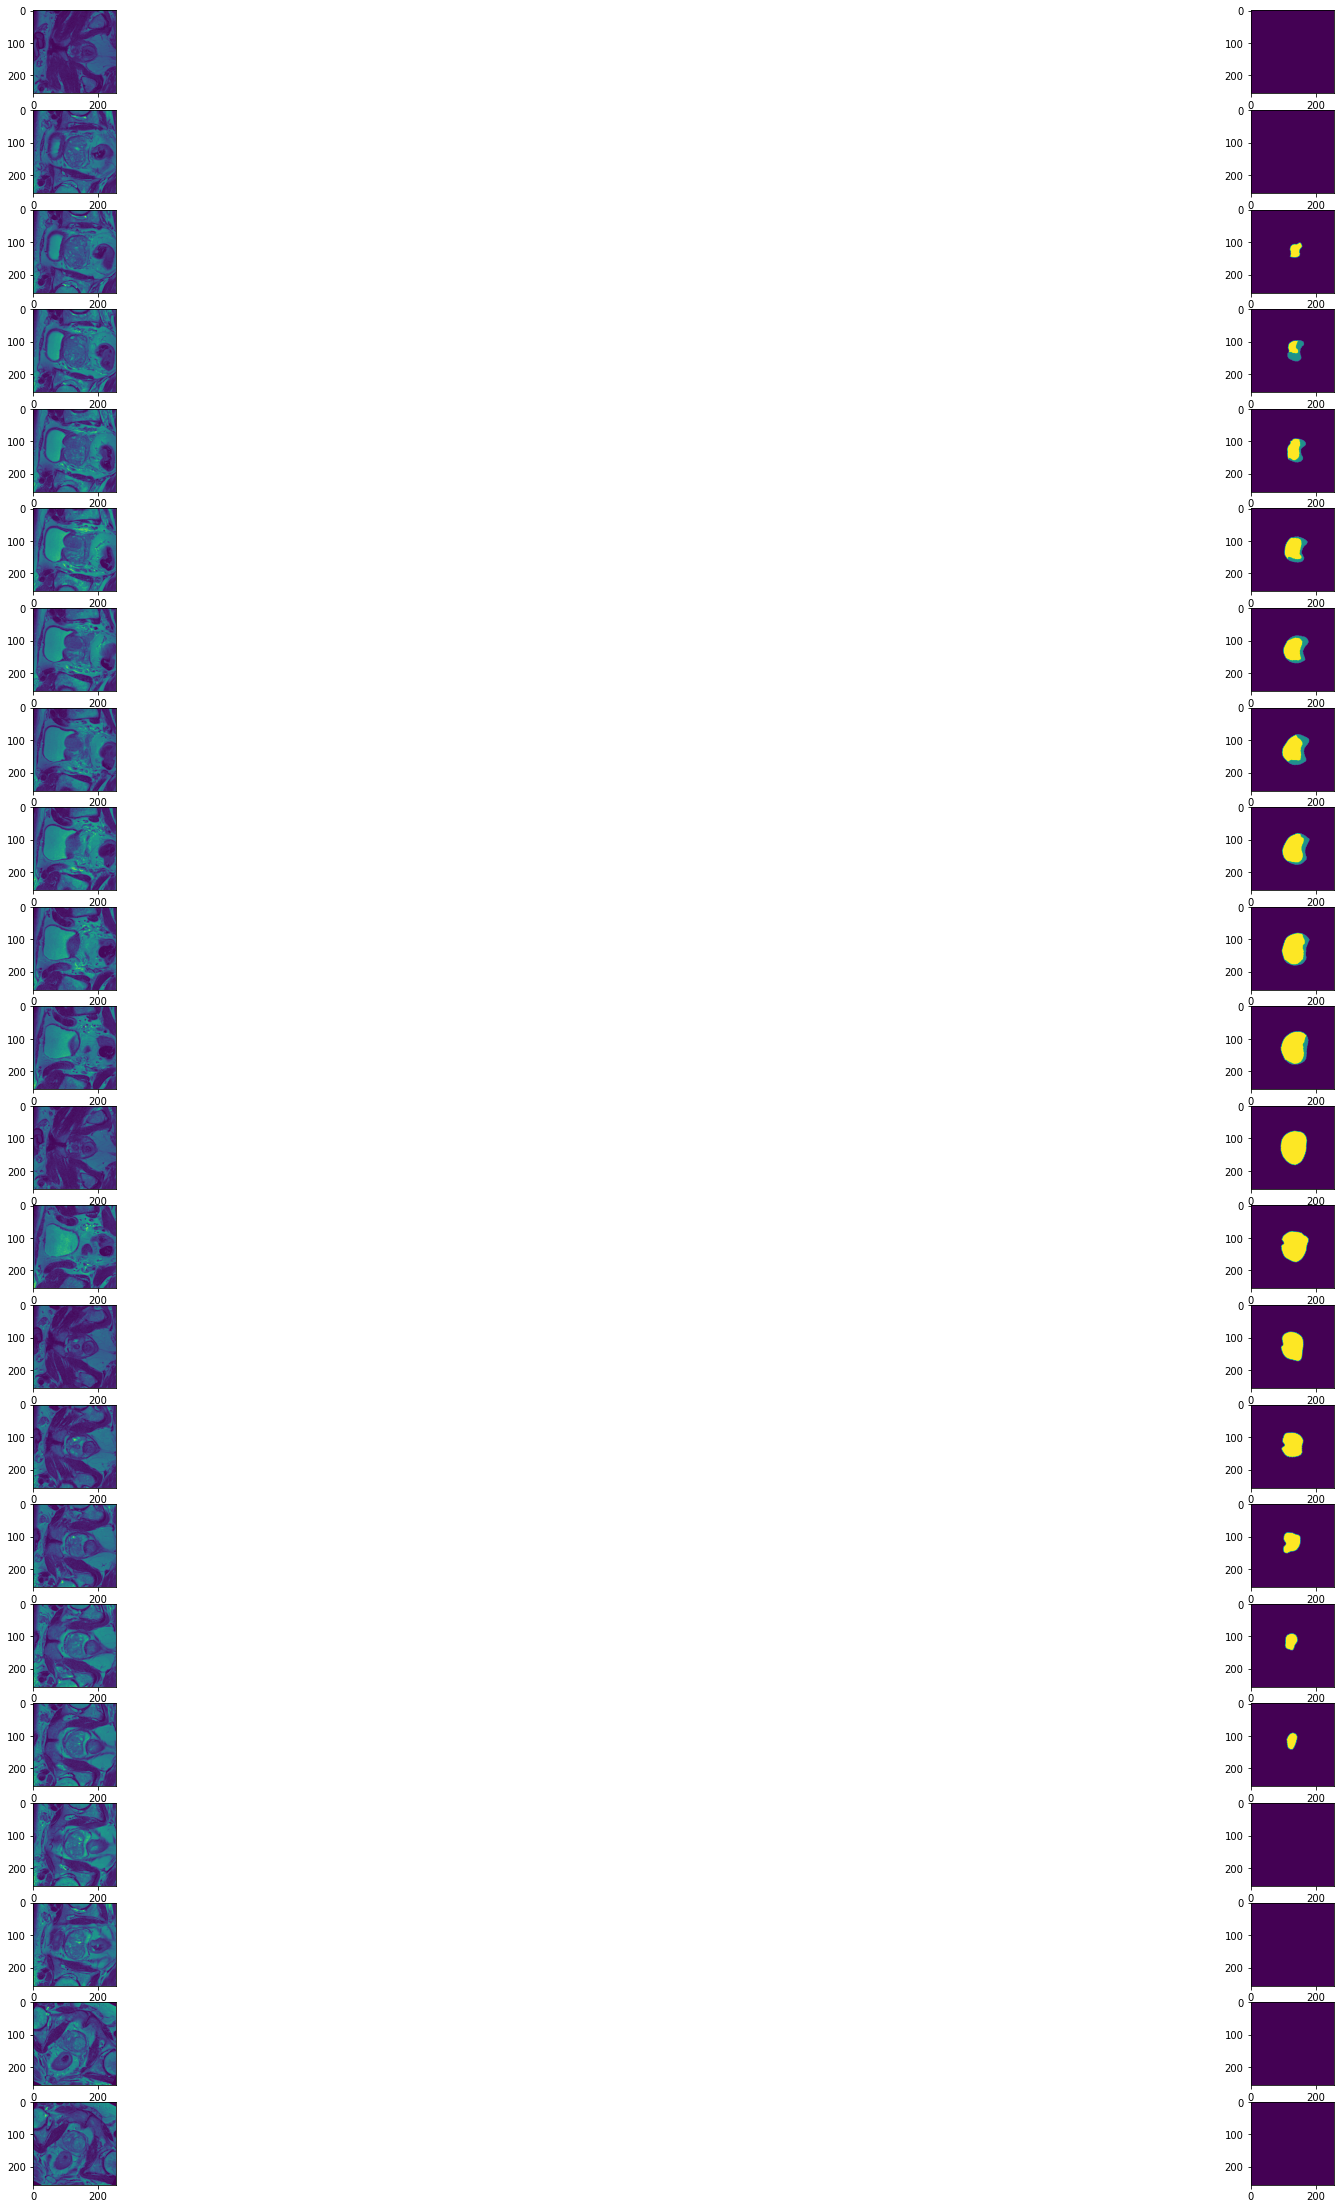

In [27]:
plt.figure(figsize=(40,40))
for i in range (0, 22):
    plt.subplot(22, 2, 2*i+1)
    plt.imshow(X_test_rot[i,:,:,0])
    plt.subplot(22, 2, 2*i+2)
    plt.imshow(Y_test_rot[i,:,:])

## Convert the labels to categorical vectors

In [28]:
Y_test_rot_vec = np.reshape(Y_test_rot, [Y_test_rot.shape[0], Y_test_rot.shape[1]*Y_test_rot.shape[2]])
print("Vectorized new label shape: %s" % (Y_test_rot_vec.shape,))

Vectorized new label shape: (175, 65536)


## Get predicted labels

In [29]:
U_net = tf.keras.models.load_model('models/U_net_' + string)
U_net.load_weights(file_path)

Y_pred_rot = U_net.predict(X_test_rot)
Y_pred_rot.shape

(175, 65536, 3)

## Evaluate the U-net

In [30]:
Y_pred_rot = np.argmax(Y_pred_rot, axis=-1)
print("New predicted labels shape: %s " % (Y_pred_rot.shape,))

New predicted labels shape: (175, 65536) 


In [31]:
def get_scores(y_true, y_pred):
    results=[]
    y_true=y_true.flatten()
    y_pred=y_pred.flatten()
    #Overall precision
    results.append(metrics.precision_score(y_true, y_pred, average='micro'))
    #Per-class precision
    results.append(metrics.precision_score(y_true, y_pred, average='macro'))
    #jaccard (right average?)
    results.append(metrics.jaccard_score(y_true, y_pred, average='macro'))
    return results
get_scores(Y_test_rot_vec, Y_pred_rot)

[0.9565896170479911, 0.802500427292948, 0.5660588654305331]

In [32]:
def get_scores(y_true, y_pred):
    results=[]
    y_true=y_true.flatten()
    y_pred=y_pred.flatten()
    #Overall precision
    results.append(metrics.precision_score(y_true, y_pred, average='micro'))
    #Per-class precision
    results.append(metrics.precision_score(y_true, y_pred, average='weighted'))
    #jaccard (right average?)
    results.append(metrics.jaccard_score(y_true, y_pred, average='weighted'))
    return results
get_scores(Y_test_rot_vec, Y_pred_rot)

[0.9565896170479911, 0.9515747881615025, 0.9224589284321707]

## Plot outcome

In [33]:
# reshape back to original dimensions
Y_pred_rot_org = np.reshape(Y_pred_rot, [Y_pred_rot.shape[0], 256, 256])
print(Y_pred_rot_org.shape)

(175, 256, 256)


In [34]:
np.unique(Y_pred_rot_org)

array([0, 1, 2])

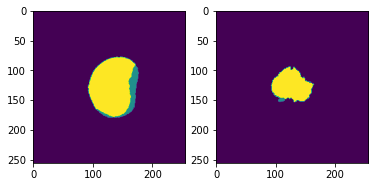

In [35]:
ind = 10
plt.subplot(1,2,1)
plt.imshow(Y_test_rot[ind])
plt.subplot(1,2,2)
plt.imshow(Y_pred_rot_org[ind])

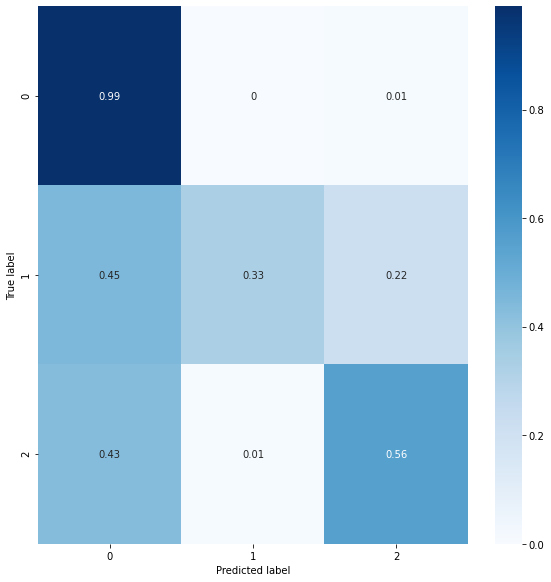

In [36]:
classes=[0,1,2]

con_mat = tf.math.confusion_matrix(labels=Y_test_rot_vec.flatten(), predictions=Y_pred_rot.flatten()).numpy()

# Normalization of Confusion Matrix to the interpretation of which class is being misclassified.
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
 
con_mat_df = pd.DataFrame(con_mat_norm, index = classes, columns = classes)

# plot confusion matrix
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()